In [1]:
using Revise

In [2]:
using Distributed
n_procs = 2
if n_procs > nprocs()
    addprocs(n_procs - nprocs())
end
;

In [3]:
@everywhere using QuantumStates, UnitsToValue
using Plots, LaTeXStrings

In [4]:
@everywhere begin
    H_X_v0 = load_from_file("CaF_X_v0", ".\\CaF_structure\\")
    H_A_v0 = load_from_file("CaF_A_v0", ".\\CaF_structure\\")
    H_B_v0 = load_from_file("CaF_B_v0", ".\\CaF_structure\\")
    H_C_v0 = load_from_file("CaF_C_v0", ".\\CaF_structure\\")
    H_D_v0 = load_from_file("CaF_D_v0", ".\\CaF_structure\\")

    N_max = 3

    # reduce rotational state space
    H_X_v0 = subspace(H_X_v0, (N=0:N_max,))
    H_A_v0 = subspace(H_A_v0, (J=1/2:(N_max+3/2),))
    H_B_v0 = subspace(H_B_v0, (N=0:(N_max+1),))
    H_C_v0 = subspace(H_C_v0, (J=1/2:(N_max+3/2),))
    H_D_v0 = subspace(H_D_v0, (N=0:(N_max+1),))
end
;

In [5]:
@everywhere begin
    QN_bounds = (
        label = "A",
        I = 1/2,
        S = 1/2,
        Λ = (-1,+1),
        N = 1:(N_max+2),
        J = 1/2:(N_max+3/2),
        v = 0
    )
    A_state_caseB_basis = order_basis_by_m(enumerate_states(HundsCaseB_Rot, QN_bounds))

    H_A_v0_caseB = convert_basis(H_A_v0, A_state_caseB_basis)
    evaluate!(H_A_v0_caseB)
    solve!(H_A_v0_caseB)

    
    QN_bounds = (
        label = "C",
        I = 1/2,
        S = 1/2,
        Λ = (-1,+1),
        N = 1:(N_max+2),
        J = 1/2:(N_max+3/2),
        v = 0
    )
    C_state_caseB_basis = order_basis_by_m(enumerate_states(HundsCaseB_Rot, QN_bounds))

    H_C_v0_caseB = convert_basis(H_C_v0, C_state_caseB_basis)
    evaluate!(H_C_v0_caseB)
    solve!(H_C_v0_caseB)
end

In [6]:
@everywhere begin 
    # w = 1e-6
    # P = 20e-3
    
    w = 0.91e-6
    P = 38e-3

    I0_trap = 2P / (π * w^2)
    # I0_trap = 1e9

    d_egAX = 5.95 * Debye
    d_egBX = 4.70 * Debye
    d_egBA = 1.09 * Debye
    d_egCA = 3.00 * Debye
    d_egDA = 4.91 * Debye

    (d_egAX, d_egBX, d_egBA, d_egCA, d_egDA) |> display
end

(1.984706395e-29, 1.56775127e-29, 3.63584869e-30, 1.0006923000000001e-29, 1.6377997310000002e-29)

      From worker 2:	(1.984706395e-29, 1.56775127e-29, 3.63584869e-30, 1.0006923000000001e-29, 1.6377997310000002e-29)


In [7]:
@everywhere begin
    Hs = [H_X_v0, H_A_v0_caseB, H_B_v0, H_C_v0_caseB, H_D_v0]
    H = CombinedHamiltonian(Hs)

    x = [1.0, 0.0, -1.0] / √2
    y = im * [1.0, 0.0, 1.0] / √2
    z = [0.0, 1.0, 0.0]
    
    # linearly polarized trap
    # θ = pi / 4
    θ = 0
    ϵ = cos(θ) * z + sin(θ) * x
    
    # X-A operator
    XA(q) = (state, state′) -> (d_egAX / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "A")
    XA_conj(q) = (state, state′) -> conj(XA(q)(state′, state))
    
    # X-B operator
    XB(q) = (state, state′) -> (d_egBX / h) * TDM(state, state′, q) * (state.label == "X") * (state′.label == "B")
    XB_conj(q) = (state, state′) -> conj(XB(q)(state′, state))

    # A-B operator
    AB(q) = (state, state′) -> (d_egBA / h) * TDM(state, state′, q) * (state.label == "A") * (state′.label == "B")
    AB_conj(q) = (state, state′) -> conj(AB(q)(state′, state))

    # A-C operator
    AC(q) = (state, state′) -> (d_egCA / h) * TDM(state, state′, q) * (state.label == "A") * (state′.label == "C")
    AC_conj(q) = (state, state′) -> conj(AC(q)(state′, state))
    
    # A-D operator
    AD(q) = (state, state′) -> (d_egDA / h) * TDM(state, state′, q) * (state.label == "A") * (state′.label == "D")
    AD_conj(q) = (state, state′) -> conj(AD(q)(state′, state))

    q = 1; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AC(q-2) + AD(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AC_conj(q-2) + AD_conj(q-2) + AB_conj(q-2)
    )
    q = 2; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AC(q-2) + AD(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AC_conj(q-2) + AD_conj(q-2) + AB_conj(q-2)
    )
    q = 3; H = add_to_H(H, Symbol("E_trap" * string(q)),
        XA(q-2) + XB(q-2) + AC(q-2) + AD(q-2) + AB(q-2) + XA_conj(q-2) + XB_conj(q-2) + AC_conj(q-2) + AD_conj(q-2) + AB_conj(q-2)
    )

    evaluate!(H)
    solve!(H)
end

### State energies versus trap intensity

In [8]:
@everywhere function H_func_neg!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(scan_values[1] / (2ε0 * c)) # should it be sqrt(scan_Values[1] / (2 * ε0 * c))?
    H.parameters.E_trap2 = ϵ[2] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(scan_values[1] / (2ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 776e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] -= trap_frequency
    end    
    solve!(H)
    
    return nothing
end
@everywhere function H_func_pos!(H, scan_values)
    H.parameters.E_trap1 = ϵ[1] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap2 = ϵ[2] * sqrt(scan_values[1] / (2ε0 * c))
    H.parameters.E_trap3 = ϵ[3] * sqrt(scan_values[1] / (2ε0 * c))
    
    evaluate!(H)
    trap_frequency = c / 776e-9
    for i ∈ (length(H.Hs[1].states)+1):length(H.states)
        H.matrix[i,i] += trap_frequency
    end    
    solve!(H)
    
    return nothing
end
;

In [9]:
Is = (0:0.015:1) .* I0_trap * 0.05
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values_neg, _ = scan_parameters_v2(H, scan_params, iterator, H_func_neg!, H -> energy.(H.states))
matrix_values_neg = hcat(values(scan_values_neg)...)'
@time scan_values_pos, _ = scan_parameters_v2(H, scan_params, iterator, H_func_pos!, H -> energy.(H.states))
matrix_values_pos = hcat(values(scan_values_pos)...)'

matrix_values = matrix_values_neg .+ matrix_values_pos
Es_rel = matrix_values .- matrix_values[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


 32.199969 seconds (10.13 M allocations: 517.681 MiB, 0.24% gc time, 1 lock conflict, 11.04% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


 29.373126 seconds (228.58 k allocations: 28.324 MiB, 0.04% gc time, 1 lock conflict, 0.36% compilation time)


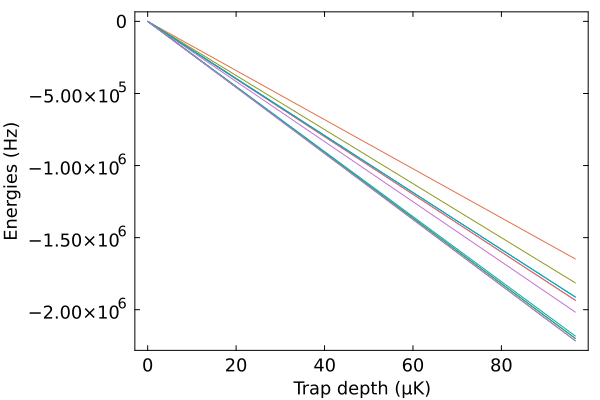

In [10]:
using Plots, LaTeXStrings
trap_depths = abs.((1e6 * h / kB) .* Es_rel)
plot(trap_depths[:,1], Es_rel[:,5:16])

plot!(
    xlabel="Trap depth (μK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )

# Solve Hamiltonian in the presence of trap

In [11]:
H.parameters.E_trap1 = 0ϵ[1] * sqrt(2I0_trap / (ε0 * c)) # no trap, bare hamiltonian
H.parameters.E_trap2 = 0ϵ[2] * sqrt(2I0_trap / (ε0 * c))
H.parameters.E_trap3 = 0ϵ[3] * sqrt(2I0_trap / (ε0 * c))

evaluate!(H)
solve!(H)

ground_state_idxs = 5:16
excited_state_idxs = 69:72
states_idxs = [ground_state_idxs; excited_state_idxs]

states_cooling_sim = H.states[states_idxs]
;

In [12]:
states_cooling_sim[12] |> display

State{HundsCaseB_Rot}(2.065705020181297e10, HundsCaseB_Rot[HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 3, 7/2, 4, -4, (N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -4.0:1.0:4.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 2, 5/2, 3, -3, (N = 0:∞, J = 1.5:1.0:2.5, F = 2.0:1.0:3.0, M = -3.0:1.0:3.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 3, 5/2, 3, -3, (N = 0:∞, J = 2.5:1.0:3.5, F = 2.0:1.0:3.0, M = -3.0:1.0:3.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 3, 7/2, 3, -3, (N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -3.0:1.0:3.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 3, 7/2, 4, -3, (N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -4.0:1.0:4.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 1, 3/2, 2, -2, (N = 0:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 2, 3/2, 2, -2, (N = 0:∞, J = 1.5:1.0:2.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, "X", 0, 1/2, 1/2, 0, 2, 5/2, 2, -2, (N = 0:∞, J = 1.5:1.0:2.5, F = 2.0:1.0:3.0, M

In [13]:
using Serialization
serialize("states_cooling_sim_tweezer.jl", states_cooling_sim)
;

# Create effective Hamiltonian in laser cooling subspace

In [14]:
@everywhere function create_effective_hamiltonian(g_idxs, e_idxs, H, H_matrix, f_ODT)

    n = length(g_idxs)
    H_eff = zeros(ComplexF64, n, n)

    for _i ∈ 1:n
        for _j ∈ 1:n
            for k ∈ e_idxs
                i = g_idxs[_i]
                j = g_idxs[_j]
                E_ground = energy(H.states[i])
                E_excited = energy(H.states[k])
                H_eff[_i,_j] -= H_matrix[i,k] * H_matrix[j,k] / (E_excited - E_ground - f_ODT)
                H_eff[_i,_j] -= H_matrix[k,i] * H_matrix[k,j] / (E_excited - E_ground + f_ODT)
            end
        end
    end

    return H_eff
end
;

In [15]:
@everywhere begin
    H_ODT_matrix = ϵ[1] .* H.operators.E_trap1.matrix .+ ϵ[2] .* H.operators.E_trap2.matrix .+ ϵ[3] .* H.operators.E_trap3.matrix

    X_idxs, _ = subspace(H.basis, (label=["X"],))
    A_idxs, _ = subspace(H.basis, (label=["A"],))
    B_idxs, _ = subspace(H.basis, (label=["B"],))
    C_idxs, _ = subspace(H.basis, (label=["C"],))
    D_idxs, _ = subspace(H.basis, (label=["D"],))

    X_N1_idxs, _ = subspace(H.basis, (label=["X"], N=[1],))
    A_J12_idxs, _ = subspace(H.basis, (label=["A"], J=[1/2],))
    
    const H_ODT_eff_g = create_effective_hamiltonian(X_N1_idxs, [A_idxs..., B_idxs...], H, H_ODT_matrix, c/776e-9)
    # const H_ODT_eff_g = create_effective_hamiltonian(X_N1_idxs, [A_idxs...], H, H_ODT_matrix, c/776e-9)
    # const H_ODT_eff_g = create_effective_hamiltonian(X_N1_idxs, [B_idxs...], H, H_ODT_matrix, c/776e-9)
    const H_ODT_eff_e = create_effective_hamiltonian(A_J12_idxs, [X_idxs..., B_idxs..., C_idxs..., D_idxs...], H, H_ODT_matrix, c/776e-9)
end
;

(64, 296, 396, 628, 728)

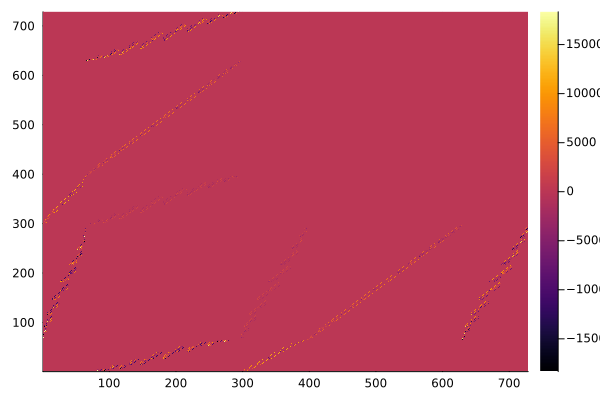

In [16]:
(length(X_idxs), length([X_idxs..., A_idxs...]), length([X_idxs..., A_idxs..., B_idxs...]), length([X_idxs..., A_idxs..., B_idxs..., C_idxs...]), length([X_idxs..., A_idxs..., B_idxs..., C_idxs..., D_idxs...])) |> display
real(H_ODT_matrix) |> heatmap

In [17]:
@everywhere begin
    HX_eff = subspace(deepcopy(H_X_v0), (N=1,))
    # evaluate!(HX_eff)
    # solve!(HX_eff)

    HA_eff = subspace(deepcopy(H_A_v0_caseB), (J=1/2,))
    # evaluate!(HA_eff)
    # solve!(HA_eff)
end
;

In [18]:
@everywhere begin
    H_ODT_matrix_g = create_matrix_for_states(H_ODT_eff_g, HX_eff.states)
    H_ODT_matrix_e = create_matrix_for_states(H_ODT_eff_e, HA_eff.states)
end
;

In [19]:
H_ODT_matrix = zeros(ComplexF64, 16, 16)
H_ODT_matrix[1:12, 1:12] .= H_ODT_matrix_g[1:12, 1:12]
H_ODT_matrix[13:16, 13:16] .= H_ODT_matrix_e[5:8, 5:8]
;

In [20]:
H_ODT_matrix[13:16,13:16]

4×4 Matrix{ComplexF64}:
 -9.27476e-6+0.0im          0.0+0.0im          0.0+0.0im          0.0+0.0im
         0.0+0.0im  -8.37465e-6+0.0im          0.0+0.0im   2.2933e-18+0.0im
         0.0+0.0im          0.0+0.0im  -8.48942e-6+0.0im          0.0+0.0im
         0.0+0.0im   2.2933e-18+0.0im          0.0+0.0im  -8.37465e-6+0.0im

-8.128018740125819e-6 + 0.0im

-8.374653965982048e-6 + 0.0im

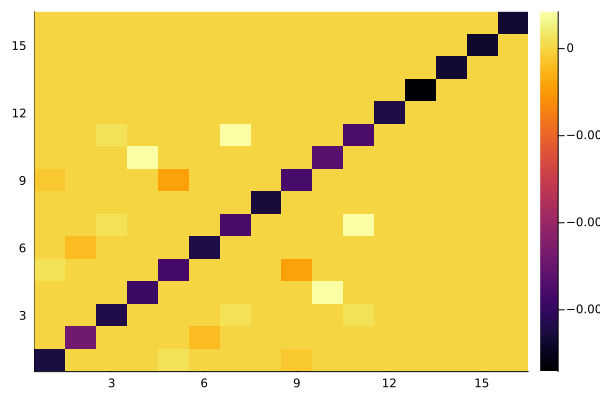

In [21]:
H_ODT_matrix[1,1] |> display
H_ODT_matrix[end, end] |> display

# tensor_stark_shift = deepcopy(H_ODT_matrix[1:12, 1:12])
# scalar_stark_shift = tensor_stark_shift[1,1]
# for idx in 1:12
#     tensor_stark_shift[idx,idx] -= scalar_stark_shift
# end

# real(tensor_stark_shift) |> heatmap
real(H_ODT_matrix) |> heatmap

In [22]:
using Serialization
serialize("H_tweezer_matrix.jl", H_ODT_matrix)
;

## Let's check the trap shifts versus energy for the effective Hamiltonian for $X(N=1)$

In [23]:
@everywhere function H_func!(H, scan_values)
    evaluate!(H)
    H.matrix .+= sqrt(scan_values[1] / (2ε0 * c))^2 .* H_ODT_eff_g
    solve!(H)
    return nothing
end
;

In [24]:
Is = (0:0.015:1) .* I0_trap
scan_params = (
    I = Is,
)
iterator = Iterators.product
    
@time scan_values, _ = scan_parameters_v2(HX_eff, scan_params, iterator, H_func!, H -> energy.(H.states))
energies = hcat(values(scan_values)...)'
energies_relative = energies .- energies[1,:]'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.275009 seconds (84.83 k allocations: 4.332 MiB, 21.81% compilation time)


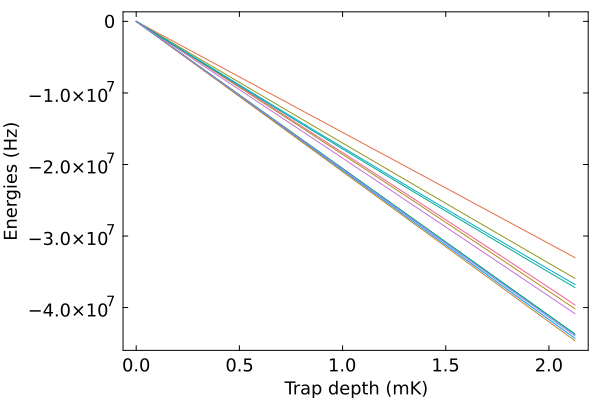

In [25]:
using Plots, LaTeXStrings
trap_depths = abs.((1e3 * h / kB) .* energies_relative)
plot(trap_depths[:,1], energies_relative[:,:])

plot!(
    xlabel="Trap depth (mK)",
    ylabel="Energies (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on,
    legend=nothing,
    # ylim=(-1e3,+1e3)
    )

In [26]:
H_g = sqrt(I0_trap / (2ε0 * c))^2 .* H_ODT_eff_g

12×12 Matrix{ComplexF64}:
 -4.50938e7+0.0im         0.0+0.0im  …         0.0+0.0im         0.0+0.0im
        0.0+0.0im  -4.09677e7+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im   2.89725e6+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im   5.02038e6+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im  …         0.0+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im            0.0+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im     -4.88867e6+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im     -3.45681e6+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im  …  -3.84414e7+0.0im         0.0+0.0im
        0.0+0.0im         0.0+0.0im            0.0+0.0im  -4.44018e7+0.0im